# Assignment 5

**Submission deadline:**
* **Normal problems: Thursday, 28.05.2020**
* **Bonus problems: Deadline of Assignment 6**

**Points: 10 + 7+ bonus points**


The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Add your solutions to the notebook.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

In [0]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

In [160]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [161]:
import collections

import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm


import torch

from tqdm import tqdm
import tabulate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [0]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [0]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [0]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [0]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [0]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]

    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2 - q1)
    # print(r2_pred.shape)
    # print(f'Mean: {r2_pred.mean(axis=1).shape}')
    # print(f'STD: {r2_pred.std(axis=1).shape}')

    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred / np.sqrt((r2_pred ** 2).sum(axis=1))[:, np.newaxis]
    vecs_norm = vecs.vec / np.sqrt((vecs.vec ** 2).sum(axis=1))[:, np.newaxis]

    # Note: First i normalized (like gaussian) using mean and std 
    #       and results were a bit better
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [90]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [91]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## Subtask 2: translation through alignment of vector spaces

In [92]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [93]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [0]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [95]:
indices_from_task = [ftext.idx2word.index(x) for x in ['congress', 'jan', 'democratic', 'rail', 'representatives', 'turned', 'beyond']]
indices_from_task

[1311, 1144, 1176, 1779, 1636, 1575, 1615]

In [97]:
def translate(W, v, vecs):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #

    
    vecs_norm = vecs.vec / np.sqrt((vecs.vec ** 2).sum(axis=1))[:, np.newaxis]

    v_t = v.dot(W)
    v_t = v_t / np.sqrt((v_t ** 2).sum())

    
    # Compute in chunks to save memory
    # r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
    #                                for i in range(0, r2_pred.shape[0], 1000)])
    
    # print(v_t.shape)
    # print(vecs_norm.shape)

    idx = np.argmax(v_t.dot(vecs_norm.T))
    return vecs.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

tr_words = indices_from_task # comment to see results for random words

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

---------------  --------------
congress         ustawodawczego
jan              móc
democratic       demokratyczny
rail             dalekobieżnych
representatives  delegatów
turned           skręcił
beyond           wykraczające
---------------  --------------


## Subtask 3: PCA

In [17]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [18]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


Plotting...: 262it [00:01, 217.62it/s]


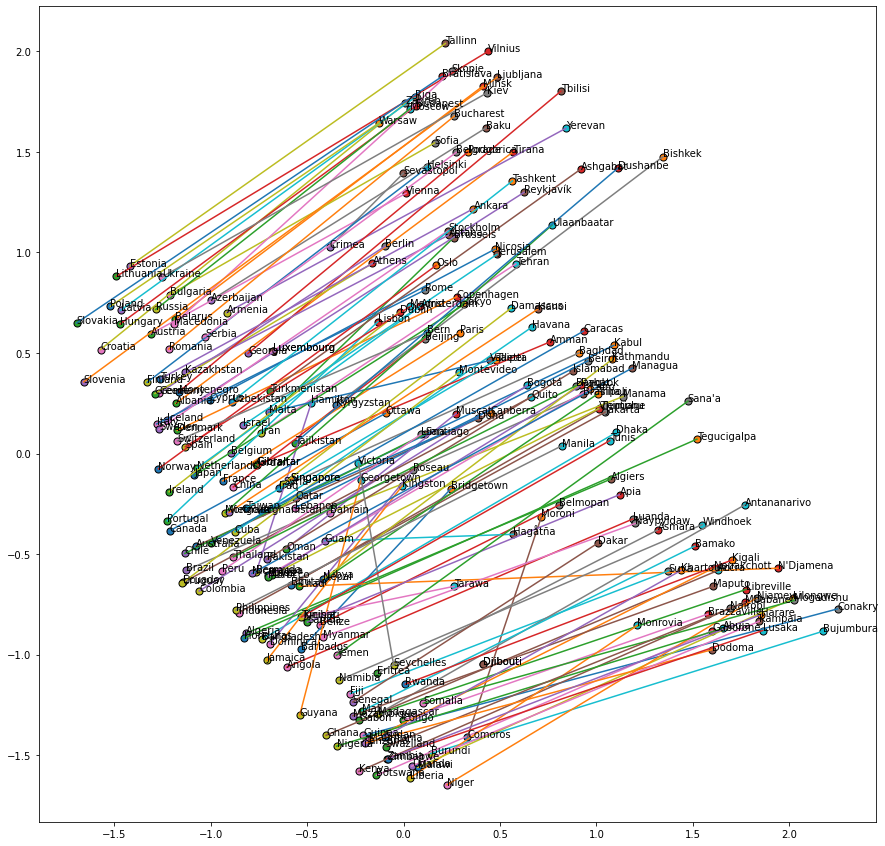

In [19]:
from sklearn.decomposition import PCA

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#

pca = PCA(n_components=2)
geo_vecs2d = pca.fit_transform(geo_vecs)

plt.figure(figsize=(15, 15))

for i, t in tqdm(enumerate(geo_vecs2d), desc='Plotting...'):
  x, y = t
  plt.scatter(x, y, edgecolors='black', s=50)
  plt.annotate(geo[i], xy=(x, y))
  if geo[i] in capitals:
    capital = capitals[geo[i]]
    idx = geo.index(capital)
    # print(f'{geo[i]} --> {capital} | {idx}')
    
    d = geo_vecs2d[idx]
    plt.plot((x, d[0]), (y, d[1]))

plt.show()

## Subtask 4: PCA vs t-SNE on frequent words

Plotting...: 400it [00:01, 234.77it/s]


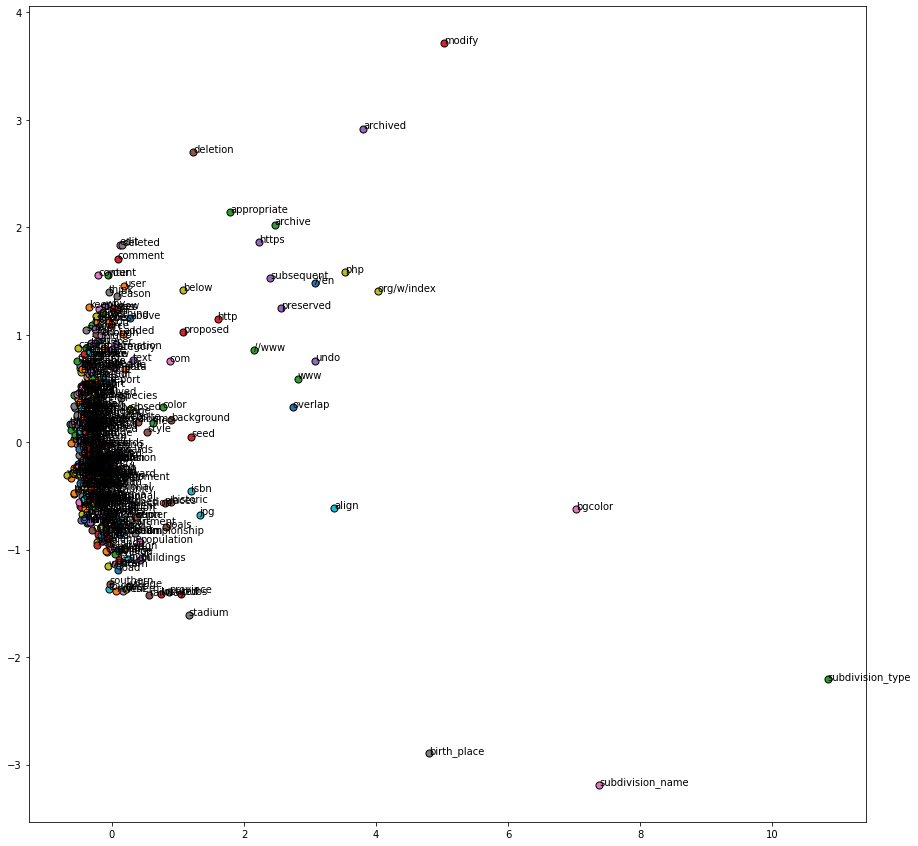

In [20]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]


#
# TODO: make a 2D PCA projection of the selected words.
#

X = ftext.vec[top_inds]

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

plt.figure(figsize=(15, 15))

for i, t in tqdm(enumerate(new_X), desc='Plotting...'):
  x, y = t
  plt.scatter(x, y, edgecolors='black', s=50)
  plt.annotate(top_words[i], xy=(x, y))

plt.show()

Plotting...: 400it [00:01, 204.11it/s]


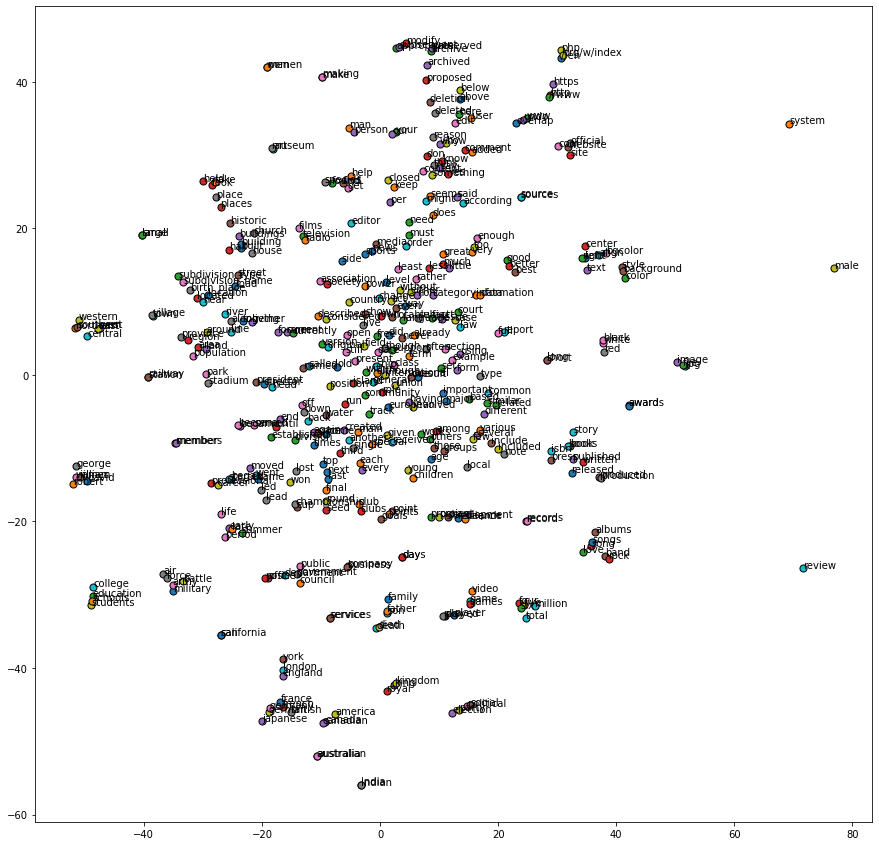

In [21]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#

tsne = TSNE(n_components=2, perplexity=5, learning_rate=10)
new_X = tsne.fit_transform(X)

plt.figure(figsize=(15, 15))

for i, t in tqdm(enumerate(new_X), desc='Plotting...'):
  x, y = t
  plt.scatter(x, y, edgecolors='black', s=50)
  plt.annotate(top_words[i], xy=(x, y))

plt.show()

Cluster 1 / 3


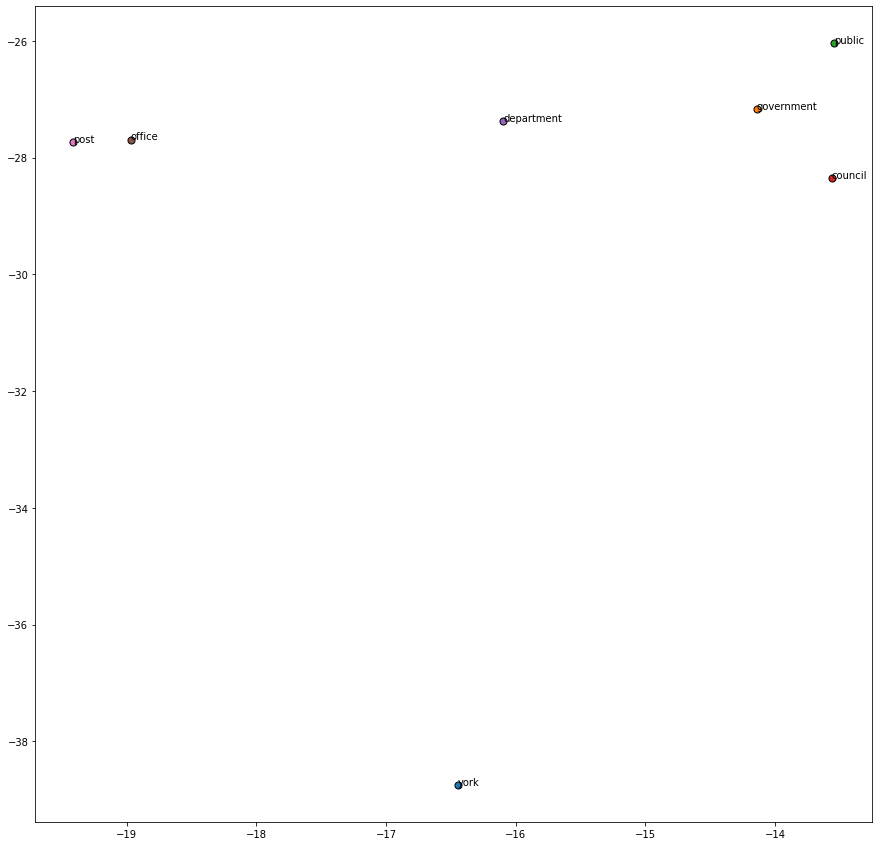

Cluster 2 / 3


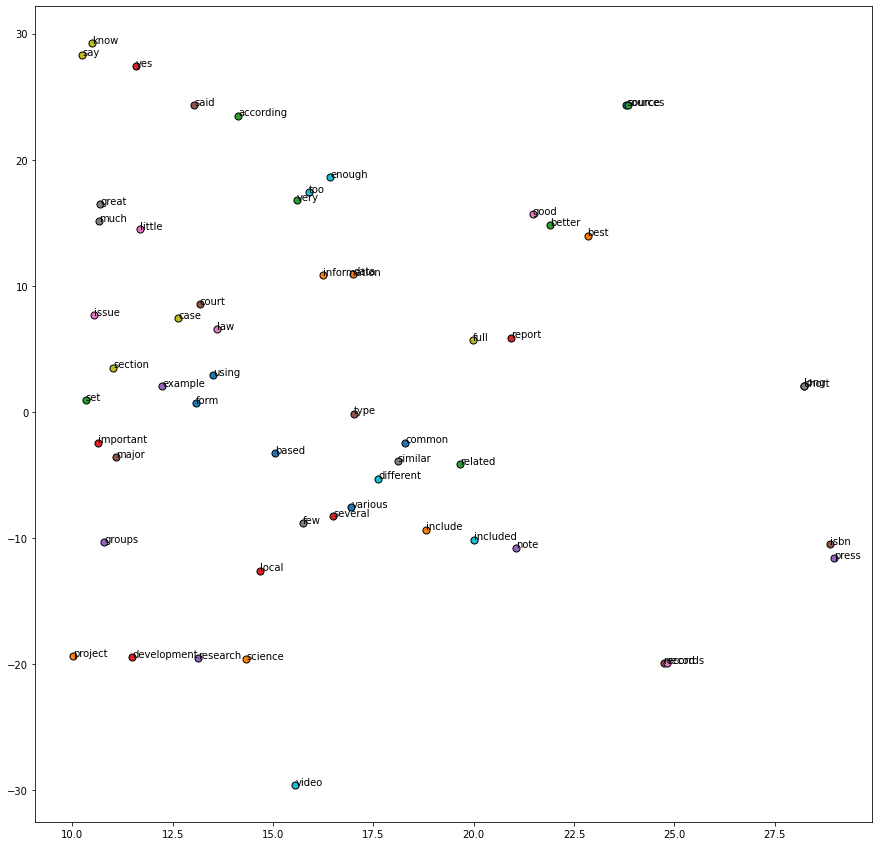

Cluster 3 / 3


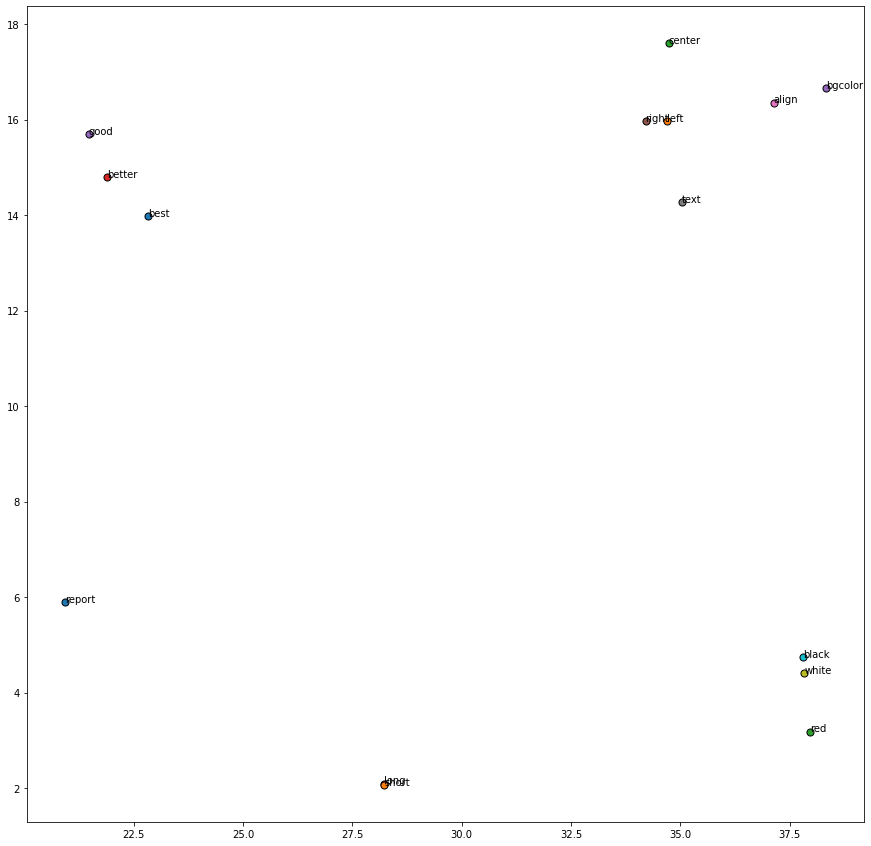

In [22]:
# TODO: zomm in on 3 meaningful clusters

Xls = [-21, 10, 20]
Xrs = [-10, 30, 40]

Yls = [-40, -30, 0]
Yrs = [-20, 30, 20]

for k in range(len(Xls)):
  print(f'Cluster {k + 1} / {len(Xls)}')
  plt.figure(figsize=(15, 15))
  for i, t in enumerate(new_X):
    x, y = t
    if Xls[k] <= x <= Xrs[k] and Yls[k] <= y <= Yrs[k]:
      plt.scatter(x, y, edgecolors='black', s=50)
      plt.annotate(top_words[i], xy=(x, y))

  plt.show()

# Problem 2: kNN Talker [6p + 7bp]

In this exercise you will build a simple chatbot that uses distributed representations of words and sentences to perform a neares neighbor selection of responses.

We have collected two sets of data:
- `./reddit_pairs.txt` of excerpts of [Reddit](https://www.reddit.com/) conversations,
- `./hackernews_pairs.txt` of excertps from [Hackernews](https://news.ycombinator.com/).

The two corpuses are formatted as `tab`-separated pairs of utterances: a `prompt` and a `response`. Successive lines belong to different conversations.

The main idea of the chatbot is to build a representation of the user `input` and of all `prompts` from the corpus. Then select the best (or randomly one of the top few) matches and print the associated `response`.

The key to get the bot working is to create good sentence representations. We will try:
- averaging word embeddings
- using sentence models such as BERT.

### Warning:
The Reddit corpus may contain abusive language, it was not heavily cleaned.

### Tasks
The code below is a starting point, but you can develop you own. The following list suggests some actions to try, along with the points that reflect our subjective hardness. The exercise is worth 6 regular points (i.e. the report, word embedding-based model and BERT-based model), anything on top of it will be counted as a bonus.

1. [MANDATORY] type in a Markdown cell a report of your actions, what did you try, why, what was the result. Show exemplary conversations (they must be probable under your model) [2p].
2. Represent sentences by averaging their word vectors. Properly handle tokenization (you can use regular expressions or e.g. `nltk` library). Describe how you handle lower and upper cased words. Try a fw nearest neighbor selection methods (such as euclidean or cosine distance). See how embedding normalization affects the results (you can normalize individual word vectors, full sentence vectors etc.) [2p]
3. Use the [transformers](https://huggingface.co/transformers) package to load a pretrained BERT model. Use it to represent sentences by e.g. averaging the activations in the last layer [2p].
4. Cherry-pick 3 nice dialogues [1p].
5. Incoportate context: keep a running average of past conversation turns [1p].
6. Do data cleaning, finding rules for good responses [1p].
7. Do profanity cleaning [1p].
8. Try mixing different sentence representation techniques [1p].
9. Try to custer responses to the highest scored prompts. Whic arsponses are more funny: form the largerst or from the smalles cluster? [2p].
10. Implement your own enhancements [?bp].


In [165]:
prompts = []
responses = []
err_lines = []
with open('./hackernews_pairs.txt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        line = line.split('\t')
        if len(line)!=2:
            err_lines.append(line)
        else:
            prompts.append(line[0])
            responses.append(line[1])
print(f"Failed to parse the following {len(err_lines)} lines: {err_lines}") 
print(f"Sample fialogue pairs: \n{pprint.pformat(list(zip(prompts[:15], responses)))}")

Failed to parse the following 0 lines: []
Sample fialogue pairs: 
[('Ah, yep, that was the issue.',
  'Yeah, options typically cost the company very little.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Oh, I see.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Whaaa?'),
 ('Quite cool.', 'It gets into a pretty philosophical area.'),
 ("If only the packaging smells, then I agree, it's not damaged.",
  'Sounds like entitlement to me.'),
 ("That's what nationalist politics always says.", 'Can you prove that?'),
 ('Misleading title.', 'Not really.'),
 ('Misleading title.',
  'It is not completely misleading to all users but enough for me to say '
  'something.'),
 ('Why the hell is this getting downvoted?',
  "Because it's clear the person he's responding to understood that "
  'relationship.'),
 ("There's a web without ads.",
  'This just came to mind when you mentioned "ad tax".'),
 ('God 

In [0]:
class BasicEncoder:
    def encode(self, sentence):
        # this is a base class!
        raise NotImplementedError

    def encode_corpus(self, sentences):
        ret = [self.encode(sentence) for sentence in tqdm(sentences)]
        return np.vstack(ret)

The code below implements a simple baseline: we encode each sentence as a sparse vector which sums word occurrences.

In [167]:
class OneHotEncoder(BasicEncoder):
    def __init__(self, sentences):
        self.vectorizer = sklearn.feature_extraction.text.CountVectorizer()
        self.vectorizer.fit(sentences)
    
    def encode(self, sentence):
        return self.vectorizer.transform([sentence])[0]

    def encode_corpus(self, sentences):
        # Override because sklearn already works on batches
        encodings = self.vectorizer.transform(sentences)
        # Note: this code needs to handl the scipy sparse matrix
        # which has subtle differences with numpy ndarrays
        norms = np.array((encodings.power(2)).sum(1))**0.5
        encodings = encodings.multiply(1.0 / norms)
        return encodings

encoder = OneHotEncoder(prompts)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Deal with encodings being sparse matrices. Word2vecs will not have the pecularities
scores = (encodings @ enc.T).toarray().ravel()
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

1.0 Question. : In a sense 'maybe not'.
1.0 Linux? : Unfortunately not.
1.0 Windows? : Unix based systems
1.0 Question. : This is a good question!
0.8017837257372732 Hardware or software or technique or best practices... : Mobile phones that still work when you drop them.
0.8017837257372732 Hardware or software or technique or best practices... : Floppy disk and cd/dvd drives!
0.8017837257372732 Hardware or software or technique or best practices... : Building your own desktop.
0.8017837257372732 Hardware or software or technique or best practices... : Extreme programming.
0.8017837257372732 Hardware or software or technique or best practices... : Zip drives.
0.8017837257372732 Hardware or software or technique or best practices... : It can all go.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [0]:
# TODO: build a simple dialogue system using these k-neares neighbor matches, 
# perform a few test conversations

In [169]:
class Word2VecEncoder(BasicEncoder):
    def __init__(self, vecs):
        self._vecs = vecs
        
    def _get_vec(self, word):
        # Find the vector for word, or use a suitbale out-of-vocabulary vector
        # For extra points try backing off to a lowercased dictionary
        if not word in self._vecs.word2idx:
          return np.zeros(self._vecs.vec.shape[1])
        idx = self._vecs.word2idx[word]
        v = self._vecs.vec[idx]
        return v

    
    def preprocess(self, sentence):
      '''
      1. Lower everything
      2. Remove punctuation
      '''
      sentence = re.sub(r'[^\w\s]', '', sentence.lower())
      return sentence


    def encode(self, sentence):
        ret = np.zeros(self._vecs.vec.shape[1])
        sentence = self.preprocess(sentence)
        for token in nltk.tokenize.word_tokenize(sentence):
            word_vec = self._get_vec(token)
            ret += word_vec
        ret /= (np.linalg.norm(ret) + 1e-5)
        return ret

encoder = Word2VecEncoder(word2vec)
encodings = encoder.encode_corpus(prompts)

100%|██████████| 52690/52690 [00:10<00:00, 5117.95it/s]


In [0]:
def bot_answer(prompt, mode, normalize=False):
  emb = encodings.copy()
  v = encoder.encode(prompt)

  if normalize:
    emb = emb / (np.sqrt((emb ** 2).sum(axis=1))[:, np.newaxis] + 1e-6)
    v = v / (np.sqrt((v ** 2).sum()) + 1e-6)

  scores = None

  if mode == 'cosine':
    scores = v.dot(emb.T).ravel()
    idx = scores.argsort()[-1]
    return scores[idx], prompts[idx], responses[idx]

  if mode == 'euclidean':
    scores = ((emb - v) ** 2).sum(axis=1)
    idx = scores.argsort()[-1]
    return scores[idx], prompts[idx], responses[idx]

  return None

In [0]:
sentences = [
  'Hello my friend',     
  'How are you?',
  'How old are you?',
  'Tell me a joke',
  'I need a dentist',
  'Hey siri'
]

### 1. Cosine distance | normalize=False

In [206]:
for s in sentences:
  a, b, c = bot_answer(s, mode='cosine', normalize=False)
  print(f'Sentence: {s} \nScore: {a} \nClosest prompt: {b} \nClosest response: {c}\n')

Sentence: Hello my friend 
Score: 0.879162306586986 
Closest prompt: Hello tearing my old friend... 
Closest response: It's time to deal with you again...

Sentence: How are you? 
Score: 0.9326878613516854 
Closest prompt: What are you, 14? 
Closest response: I was agreeing with you?

Sentence: How old are you? 
Score: 0.9999963392940913 
Closest prompt: How old are you? 
Closest response: I'm 30, with very millennial attitudes except not as anti-establishment.

Sentence: Tell me a joke 
Score: 0.8388911265054113 
Closest prompt: Tell me about it. 
Closest response: Strike while the iron is hot.

Sentence: I need a dentist 
Score: 0.7036548314567893 
Closest prompt: I can't speak to dental stuffs, but some local anesthetics don't work on me. 
Closest response: I feel like dental work is harder.

Sentence: Hey siri 
Score: 0.9999918109247432 
Closest prompt: Hey. 
Closest response: Thank you for the kind offer, I will see how things progress next week.



### 2. Cosine distance | normalize=True

In [207]:
for s in sentences:
  a, b, c = bot_answer(s, mode='cosine', normalize=True)
  print(f'Sentence: {s} \nScore: {a} \nClosest prompt: {b} \nClosest response: {c}\n')

Sentence: Hello my friend 
Score: 0.8791630224133191 
Closest prompt: Hello tearing my old friend... 
Closest response: It's time to deal with you again...

Sentence: How are you? 
Score: 0.9326900118019887 
Closest prompt: What are you, 14? 
Closest response: I was agreeing with you?

Sentence: How old are you? 
Score: 0.9999979999993394 
Closest prompt: How old are you? 
Closest response: I'm 30, with very millennial attitudes except not as anti-establishment.

Sentence: Tell me a joke 
Score: 0.8388923462943676 
Closest prompt: Tell me about it. 
Closest response: Strike while the iron is hot.

Sentence: I need a dentist 
Score: 0.7036553450005972 
Closest prompt: I can't speak to dental stuffs, but some local anesthetics don't work on me. 
Closest response: I feel like dental work is harder.

Sentence: Hey siri 
Score: 0.9999979999948109 
Closest prompt: Hey. 
Closest response: Thank you for the kind offer, I will see how things progress next week.



### 3. Euclidean distance | normalize=False

In [208]:
for s in sentences:
  a, b, c = bot_answer(s, mode='euclidean', normalize=False)
  print(f'Sentence: {s} \nScore: {a} \nClosest prompt: {b} \nClosest response: {c}\n')

Sentence: Hello my friend 
Score: 2.2271990389686405 
Closest prompt: Scale 
Closest response: And perhaps security.

Sentence: How are you? 
Score: 2.164529433392473 
Closest prompt: Seconded. 
Closest response: It's not that simple.

Sentence: How old are you? 
Score: 2.186479791005241 
Closest prompt: Seconded. 
Closest response: It's not that simple.

Sentence: Tell me a joke 
Score: 2.1151845406455836 
Closest prompt: Thermal expansion? 
Closest response: I can't tell what your actual question is.

Sentence: I need a dentist 
Score: 2.1139772192440556 
Closest prompt: Thrived? 
Closest response: As far as I know, this is an irregular verb, but I may be wrong.

Sentence: Hey siri 
Score: 2.159542525209002 
Closest prompt: A directed thermite pellet. 
Closest response: What do you need it for?



### 4. Euclidean distance | normalize=True

In [209]:
for s in sentences:
  a, b, c = bot_answer(s, mode='euclidean', normalize=True)
  print(f'Sentence: {s} \nScore: {a} \nClosest prompt: {b} \nClosest response: {c}\n')

Sentence: Hello my friend 
Score: 2.227206838789187 
Closest prompt: Scale 
Closest response: And perhaps security.

Sentence: How are you? 
Score: 2.1645357299695194 
Closest prompt: Seconded. 
Closest response: It's not that simple.

Sentence: How old are you? 
Score: 2.186485525817154 
Closest prompt: Seconded. 
Closest response: It's not that simple.

Sentence: Tell me a joke 
Score: 2.115188452224218 
Closest prompt: Thermal expansion? 
Closest response: I can't tell what your actual question is.

Sentence: I need a dentist 
Score: 2.113984502532075 
Closest prompt: Thrived? 
Closest response: As far as I know, this is an irregular verb, but I may be wrong.

Sentence: Hey siri 
Score: 2.1595518182682305 
Closest prompt: A directed thermite pellet. 
Closest response: What do you need it for?

